In [1]:
from feature_selection_vif import select_features

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#sklearn models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor

from prettytable import PrettyTable
import joblib
import os

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

### Load data

In [2]:
cleaned_df = pd.read_csv('./data/cleaned_rainfall_data.csv') 

In [3]:
cleaned_df.head()

,time,omega_x,omega_y,omega,pr_wtr,rhum_x,rhum_y,rhum,slp,tmp_y,tmp,uwnd_x,uwnd_y,uwnd,vwnd_x,vwnd_y,vwnd
0,1948-01-01,0.043999,-0.005003,-0.050001,9.959991,22.25,42.50,47.500015,101910.0,281.41998,296.07000,16.120010,4.600006,-1.879990,-1.209992,-0.589996,-1.989990
1,1948-01-02,0.094997,0.104998,0.006998,9.519989,19.50,32.75,51.250015,102190.0,282.12000,295.99000,18.000015,3.570007,-3.589996,-5.759995,-4.379990,-4.009995
2,1948-01-03,0.038998,0.036999,0.013998,10.220001,25.50,25.50,52.750015,102222.0,282.25000,295.91998,13.820007,3.570007,-2.759994,-3.939987,-1.909988,-1.259994
3,1948-01-04,0.264997,0.215998,0.077997,9.470001,11.25,15.75,50.500015,102042.0,282.20000,295.87000,14.750015,5.000015,-1.089996,-16.789993,-7.789993,-5.259995
4,1948-01-05,0.100998,0.128998,0.016998,11.269989,39.75,33.25,47.000015,102215.0,282.34998,295.80000,27.470001,9.320007,-3.309998,-12.139984,-6.079987,-3.259994


### Splitting the data into Train and Test Sets
Since it is a time series data, it will be splited on the time axis in order to avoid data leakage.

In [4]:
cleaned_df['time'] = pd.to_datetime(cleaned_df['time'])
cleaned_df.set_index('time', inplace=True)

In [5]:
# Seperating the features from the target
features_data = cleaned_df.drop('pr_wtr', axis=1)
target = cleaned_df['pr_wtr']

# Splitting the data into train and test, 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(features_data, target, test_size=0.2, shuffle=False)


#### Further Splitting the Train data into Training and Cross Validation Sets

In [6]:
# Splitting the train set into train and cross validation, 70% of 80% for Train and 30% of 80% for cross validation.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.3, shuffle=False)

print(len(X_train))
print(len(X_cv))
print(len(y_train))
print(len(y_cv))

14522
6224
14522
6224


### Feature selection using the "Variance Inflation Factor (VIF)" method.
#### Using the Variance Inflation Factor (VIF) method to check and remove Multicollinearity

The VIF directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question. Simply put, it gauges how much a feature’s inclusion contributes to the overall variance of the coefficients of the features in the model.

A VIF of 1 indicates that the feature has no correlation with any of the other features. It is given by the equation below:

$$ VIF_i = \frac{1}{1-R_i^2} $$

Where $R_i^2$ represents the unadjusted coefficient of determination for regressing the $i^{th}$ independent variable on the remaining ones. The reciprocal of VIF is known as tolerance. Either VIF or tolerance can be used to detect multicollinearity, depending on personal preference.

If $R_i^2$ is equal to 0 (implies VIF = 1), the variance of the remaining independent variables cannot be predicted from the $i^{th}$ independent variable. Therefore, the $i^{th}$ independent variable is not correlated to the remaining ones, which means multicollinearity does not exist. In this case, the variance of the $i^{th}$ regression coefficient is not inflated.  

Statsmodels provides us with a function called `variance_inflation_factor` for the computation, we utilized it.

In [7]:
#perform feature selection using the above functions
#df = cleaned_df.drop(['pr_wtr'], axis=1) #time and pr_wtr are excluded from the exercise
threshold = 5
vif_df, features = select_features(X_train, threshold)

### Sanitary check => display the VIF dataframe and the selected features

In [8]:
display(vif_df)
print(features)

,Feature,Vif Factor
0,vwnd_y,4.129071
1,vwnd,3.892691
2,vwnd_x,3.404112
3,omega,3.239112
4,omega_x,3.220735
5,uwnd_x,2.568413
6,slp,2.409215
7,rhum_y,1.975518
8,tmp,1.673660
9,uwnd,1.660083


Index(['omega_x', 'omega', 'rhum_x', 'rhum_y', 'rhum', 'slp', 'tmp', 'uwnd_x',
       'uwnd', 'vwnd_x', 'vwnd_y', 'vwnd'],
      dtype='object')


### Making a train dataframe with the selected features

In [9]:
# make a dataframe of the selected features
X_train = X_train[features]
X_train.head()

,omega_x,omega,rhum_x,rhum_y,rhum,slp,tmp,uwnd_x,uwnd,vwnd_x,vwnd_y,vwnd
time,,,,,,,,,,,,
1948-01-01,0.043999,-0.050001,22.25,42.50,47.500015,101910.0,296.07000,16.120010,-1.879990,-1.209992,-0.589996,-1.989990
1948-01-02,0.094997,0.006998,19.50,32.75,51.250015,102190.0,295.99000,18.000015,-3.589996,-5.759995,-4.379990,-4.009995
1948-01-03,0.038998,0.013998,25.50,25.50,52.750015,102222.0,295.91998,13.820007,-2.759994,-3.939987,-1.909988,-1.259994
1948-01-04,0.264997,0.077997,11.25,15.75,50.500015,102042.0,295.87000,14.750015,-1.089996,-16.789993,-7.789993,-5.259995
1948-01-05,0.100998,0.016998,39.75,33.25,47.000015,102215.0,295.80000,27.470001,-3.309998,-12.139984,-6.079987,-3.259994


### Normalization and Standardization.
**Note:** Only the train set will be scaled or normalized to avoid data leakage.

In [10]:
# Normalizing and Standardizing the train data.
min_max_scaler = MinMaxScaler()
stand_scaler = StandardScaler()
#min_max_norm_data = min_max_scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(stand_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

#### Transform the Cross validation and Test data

In [11]:
X_cv_scaled = pd.DataFrame(stand_scaler.transform(X_cv[features]), columns=X_train.columns, index=X_cv.index)
X_test_scaled = pd.DataFrame(stand_scaler.transform(X_test[features]), columns=X_train.columns, index=X_test.index)

### Modeling

In [12]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x: cross validation features dataset
    y: cross validation target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    mape = mean_absolute_percentage_error(y, predicted)
    
    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print()

## Modeling with Different Regressors

In [13]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {'Linear Reg': LinearRegression(), 'DT Regressor': DecisionTreeRegressor(random_state=0),
          'RF Regressor':RandomForestRegressor(random_state=0), 'Lasso': LassoCV(random_state=0), 'Ridge Regressor': RidgeCV(),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0), 'SGDRegressor': SGDRegressor(random_state=0)
         }

#looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively
for key, model in models_dict.items():
    model.fit(X_train_scaled, y_train)
    print(f'Performance of "{key}" on Validation and Test set:')
    print('=='*28)
    print ( 'Validation set:')
    print("**"*8)
    evaluate_model(model,X_cv_scaled, y_cv)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,X_test_scaled, y_test)

Performance of "Linear Reg" on Validation and Test set:
Validation set:
****************
MAE: 2.84
MAPE: 0.23

Test set:
****************
MAE: 2.83
MAPE: 0.26

Performance of "DT Regressor" on Validation and Test set:
Validation set:
****************
MAE: 2.85
MAPE: 0.17

Test set:
****************
MAE: 2.84
MAPE: 0.20

Performance of "RF Regressor" on Validation and Test set:
Validation set:
****************
MAE: 1.94
MAPE: 0.12

Test set:
****************
MAE: 2.00
MAPE: 0.15

Performance of "Lasso" on Validation and Test set:
Validation set:
****************
MAE: 2.84
MAPE: 0.23

Test set:
****************
MAE: 2.82
MAPE: 0.26

Performance of "Ridge Regressor" on Validation and Test set:
Validation set:
****************
MAE: 2.84
MAPE: 0.23

Test set:
****************
MAE: 2.83
MAPE: 0.26

Performance of "xgboost" on Validation and Test set:
Validation set:
****************
MAE: 1.99
MAPE: 0.12

Test set:
****************
MAE: 2.15
MAPE: 0.14

Performance of "Gradient Boost" on Vali

### Retraining the best model (XGBoost)

In [14]:
model = XGBRegressor()
model.fit(X_train_scaled, y_train)
# Evaluate the model by calling the "evaluate_model" function defined above
print('Cross validation scores:')
print('=='*12)
evaluate_model(model, X_cv_scaled, y_cv)

print('Test scores:')
print('=='*6)
evaluate_model(model, X_test_scaled, y_test)


Cross validation scores:
MAE: 1.99
MAPE: 0.12

Test scores:
MAE: 2.15
MAPE: 0.14



### Obtain the Feature Importance

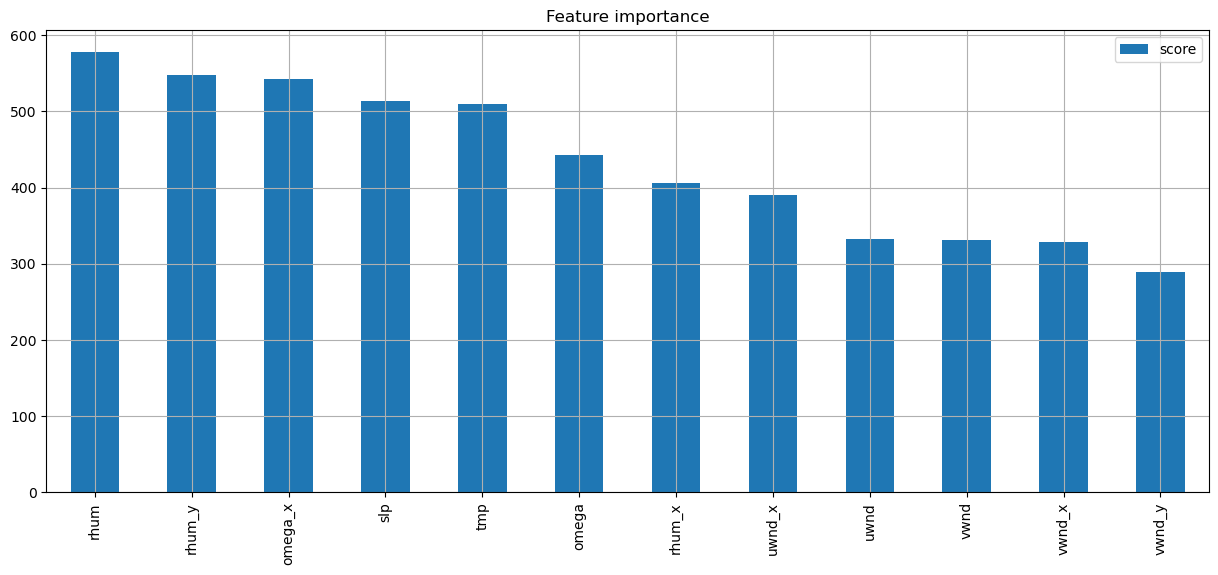

In [15]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#data.nlargest(12, columns="score").plot(kind='barh', figsize = (15,6)) ## plot top 12 features
data.plot(kind='bar',figsize=(15,6), title='Feature importance')
plt.grid()

### Make a dataframe of the most important features from X_train

In [16]:
most_important_features = X_train.drop([ 'vwnd', 'vwnd_x', 'vwnd_y'], axis=1).columns
new_X_train = X_train[most_important_features]
new_X_train.head()

,omega_x,omega,rhum_x,rhum_y,rhum,slp,tmp,uwnd_x,uwnd
time,,,,,,,,,
1948-01-01,0.043999,-0.050001,22.25,42.50,47.500015,101910.0,296.07000,16.120010,-1.879990
1948-01-02,0.094997,0.006998,19.50,32.75,51.250015,102190.0,295.99000,18.000015,-3.589996
1948-01-03,0.038998,0.013998,25.50,25.50,52.750015,102222.0,295.91998,13.820007,-2.759994
1948-01-04,0.264997,0.077997,11.25,15.75,50.500015,102042.0,295.87000,14.750015,-1.089996
1948-01-05,0.100998,0.016998,39.75,33.25,47.000015,102215.0,295.80000,27.470001,-3.309998


### Refit the Standard Scaler
Because the Standard Scaler was initially fitted with 12 features, it has to be refitted with the new number of features in order not to run into error while transforming the test or any new unseen data

In [17]:
scaler = StandardScaler()
#min_max_norm_data = min_max_scaler.fit_transform(X_train)
new_X_train_scaled = pd.DataFrame(scaler.fit_transform(new_X_train), columns=new_X_train.columns, index=new_X_train.index)

In [18]:
# Transform the cross validation and the test data with the new "scaler"
new_X_cv_scaled = pd.DataFrame(scaler.transform(X_cv[most_important_features]),
                               columns=new_X_train.columns,index=X_cv.index)

new_X_test_scaled = pd.DataFrame(scaler.transform(X_test[most_important_features]),
                                 columns=new_X_train.columns, index=X_test.index)

<AxesSubplot:xlabel='pr_wtr'>

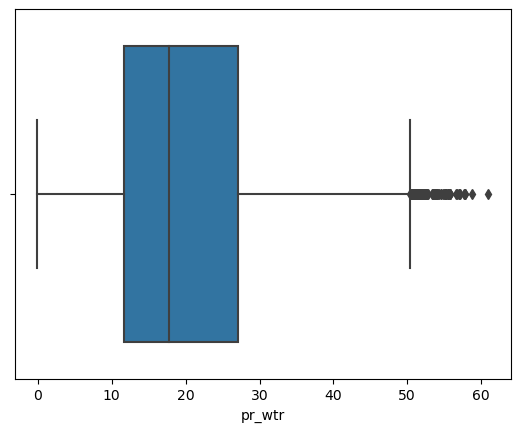

In [19]:
import seaborn as sns
sns.boxplot(y_train)

In [20]:
(y_train<= 2.5).sum()

74

In [21]:
X_test.head()

,omega_x,omega_y,omega,rhum_x,rhum_y,rhum,slp,tmp_y,tmp,uwnd_x,uwnd_y,uwnd,vwnd_x,vwnd_y,vwnd
time,,,,,,,,,,,,,,,
2004-10-19,0.000998,-0.023003,-0.011002,9.50,25.500000,31.50,101305.0,294.15000,300.20000,13.030014,3.480011,1.280014,2.130005,0.030014,-1.389999
2004-10-20,0.030998,0.001999,-0.049002,4.25,40.250004,34.00,101345.0,294.00000,300.18000,16.530014,7.300003,2.620010,-0.369995,-0.439987,-0.239990
2004-10-21,0.083998,0.054998,0.014997,1.75,20.750000,37.75,101663.0,293.12000,300.09998,13.280014,5.970001,0.550003,-2.069992,-1.819992,-1.369995
2004-10-22,0.062998,0.051998,-0.006002,5.50,9.250000,29.75,101748.0,292.72000,300.09998,12.550003,2.380005,3.080002,-2.239990,-3.769989,-1.469986
2004-10-23,0.054998,0.021997,0.025997,19.00,40.500004,29.50,101515.0,292.59998,300.00000,13.950012,1.600006,2.450012,-2.019989,-1.869995,-0.839996


### Retrain the model with only the most important features (9 features)

In [22]:
new_model = XGBRegressor()
new_model.fit(new_X_train_scaled, y_train)
# Evaluate the model by calling the "evaluate_model" function defined above
print('Cross validation scores:')
print('=='*12)
evaluate_model(new_model, new_X_cv_scaled, y_cv)

print('Test scores:')
print('=='*6)
evaluate_model(new_model, new_X_test_scaled, y_test)


Cross validation scores:
MAE: 2.01
MAPE: 0.12

Test scores:
MAE: 2.14
MAPE: 0.14



### Observation
The MAPE value of **0.14** indicates that on average the forecasts over the whole time period were less than 14% away from the actual values.

### Predictions

In [23]:
# Visualize the performance on Cross validation data
#Cross validation
yhat_cv = new_model.predict(new_X_cv_scaled) # predict on cross validation data
yhat_cv = pd.Series(yhat_cv, index=y_cv.index) #make it have same date index as the y_cv series

# Test
yhat_test = new_model.predict(new_X_test_scaled) #predict on test data
yhat_test = pd.Series(yhat_test, index=y_test.index) #make it have same date index as the y_test series

### Visualize the performance on Cross validation  and Test data

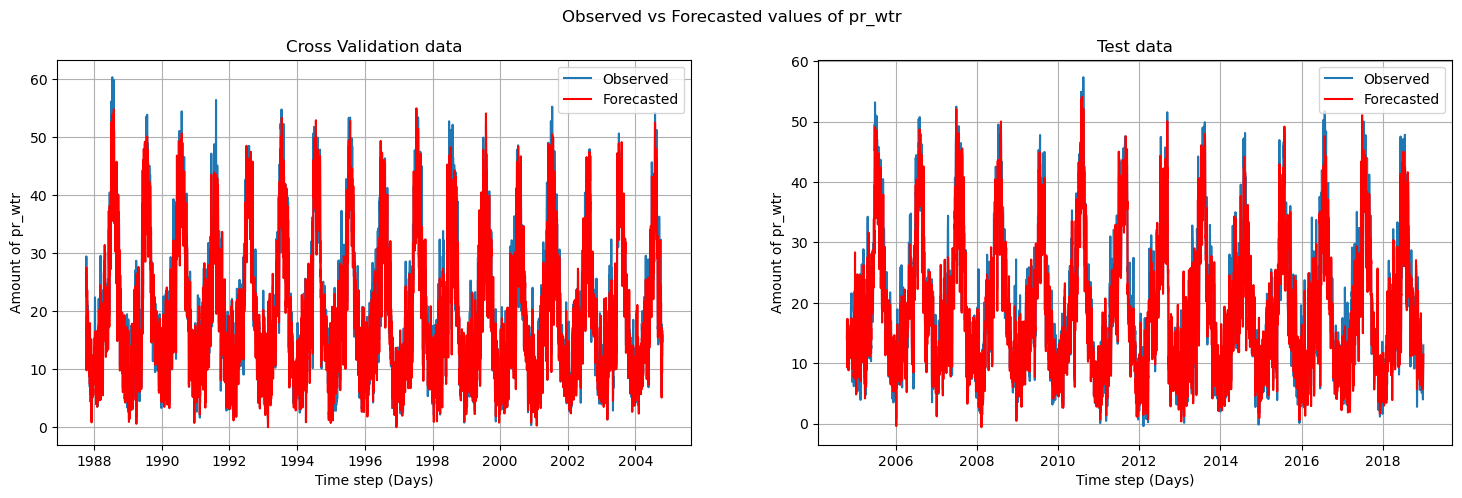

In [24]:
# Plot the cross validation predictions and the true cv values
fig = plt.figure(figsize=(18,5))
fig.suptitle('Observed vs Forecasted values of pr_wtr')
ax1 = fig.add_subplot(121)
ax1.set_title('Cross Validation data')
ax1.plot(y_cv, label='Observed')
ax1.plot(yhat_cv, color='r', label='Forecasted')
plt.ylabel('Amount of pr_wtr')
plt.xlabel('Time step (Days)')
plt.legend()
plt.grid()

# Plot the test predictions and true values
ax2 = fig.add_subplot(122)
ax2.set_title('Test data')
ax2.plot(y_test, label='Observed')
ax2.plot(yhat_test, color='r', label='Forecasted')
plt.ylabel('Amount of pr_wtr')
plt.xlabel('Time step (Days)')
plt.legend()
plt.grid()
plt.show()

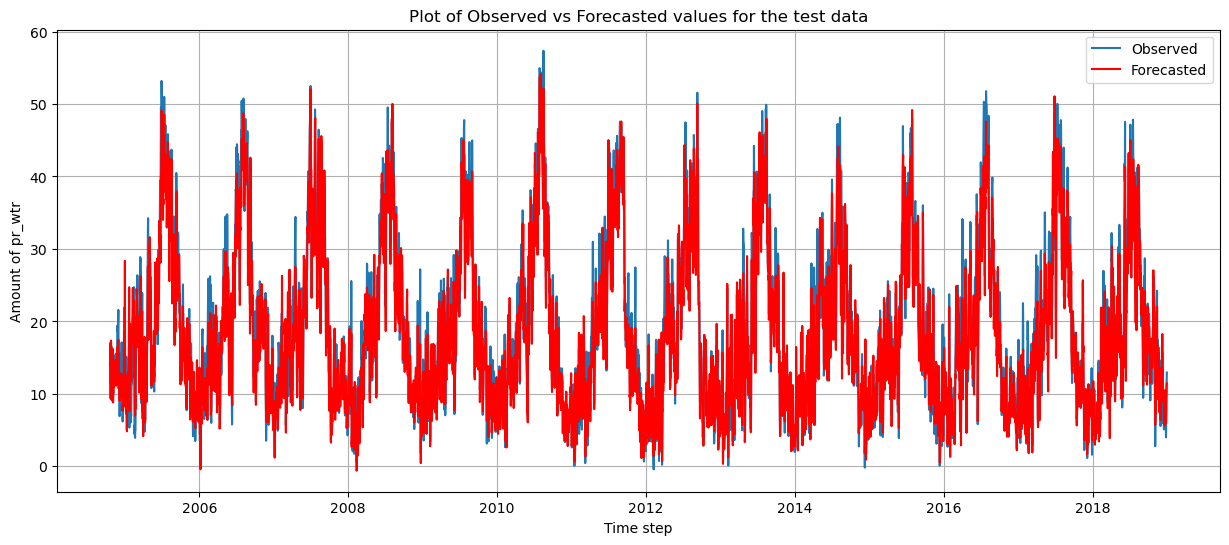

In [25]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(y_test, label='Observed')
plt.plot(yhat_test, color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values for the test data')
plt.ylabel('Amount of pr_wtr')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.show()

## Save the best model (XGBoost) and the Standard scaler object

In [26]:
# Saving the model in the current working directory
if not os.path.exists('./deployment/model'):
    os.makedirs('./deployment/model')
joblib.dump(new_model, './deployment/model/rainfall_forecast.pkl')
joblib.dump(scaler, './deployment/model/scaler.pkl')

['./deployment/model/scaler.pkl']

### Test Saved model

In [28]:
# Load the model from disk for prediction.
rainfall_model = joblib.load('./deployment/model/rainfall_forecast.pkl')

# Load the Standard scaler object
scaler = joblib.load('./deployment/model/scaler.pkl')

# Testing the loaded model on test data.
scaled_X_test = scaler.transform(X_test[most_important_features])
y_predict = rainfall_model.predict(scaled_X_test)

# Evaluating the saved model.
mae = mean_absolute_error(y_true=y_test, y_pred=y_predict)
mape = mean_absolute_percentage_error(y_test, y_predict)
    
# Print the evaluation scores.
print('MAE: {:.2f}'.format(mae))
print('MAPE: {:.2f}'.format(mape))

MAE: 2.14
MAPE: 0.14


### Model Comparison

In [29]:
# Constructing the result summary table containing the scores for each model on cross validation and test dataset.

task1_result = PrettyTable()
task1_result.field_names = ["Regressor", "MAE on CV", "MAE on Test", "MAPE on CV", "MAPE on Test"]
task1_result.add_row(['Linear Reg', 2.84, 2.83, 0.23, 0.26])
task1_result.add_row(['DT Reg', 2.85, 2.84, 0.17, 0.20])
task1_result.add_row(['RF Reg', 1.94, 2.00, 0.12, 0.15])
task1_result.add_row(['Lasso Reg', 2.84, 2.82, 0.23, 0.26])
task1_result.add_row(['Ridge Reg', 2.84, 2.83, 0.23, 0.26])
task1_result.add_row(['XGBoost', 1.99, 2.15, 0.12, 0.14])
task1_result.add_row(['GradientBoost', 2.11, 2.14, 0.13, 0.15])
task1_result.add_row(['SGD Reg', 2.84, 2.84, 0.23, 0.27])
task1_result.add_row(['Prophet', 2.29, 2.29, 0.20, 0.20])

print('Result Summary for All Regressors:')
print(task1_result)

Result Summary for All Regressors:
+---------------+-----------+-------------+------------+--------------+
|   Regressor   | MAE on CV | MAE on Test | MAPE on CV | MAPE on Test |
+---------------+-----------+-------------+------------+--------------+
|   Linear Reg  |    2.84   |     2.83    |    0.23    |     0.26     |
|     DT Reg    |    2.85   |     2.84    |    0.17    |     0.2      |
|     RF Reg    |    1.94   |     2.0     |    0.12    |     0.15     |
|   Lasso Reg   |    2.84   |     2.82    |    0.23    |     0.26     |
|   Ridge Reg   |    2.84   |     2.83    |    0.23    |     0.26     |
|    XGBoost    |    1.99   |     2.15    |    0.12    |     0.14     |
| GradientBoost |    2.11   |     2.14    |    0.13    |     0.15     |
|    SGD Reg    |    2.84   |     2.84    |    0.23    |     0.27     |
|    Prophet    |    2.29   |     2.29    |    0.2     |     0.2      |
+---------------+-----------+-------------+------------+--------------+
